In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score
from src.helper import get_split_data

In [2]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(6)

In [3]:
params = {'colsample_bytree': 0.8829682348067726,
              'gamma': 2.153140019195803,
              'learning_rate': 0.2839181641252695,
              'max_depth': 10,
              'n_estimators': 750,
              'reg_alpha': 0.05456053939633371,
              'reg_lambda': 0.014211434927705319,
              'subsample': 0.8413541436147373
          }

xg = xgb.XGBClassifier(**params, random_state=42)
xg.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred = xg.predict(X_tst)

f1_score(y_tst, y_pred, average='binary').round(3)

np.float64(0.333)

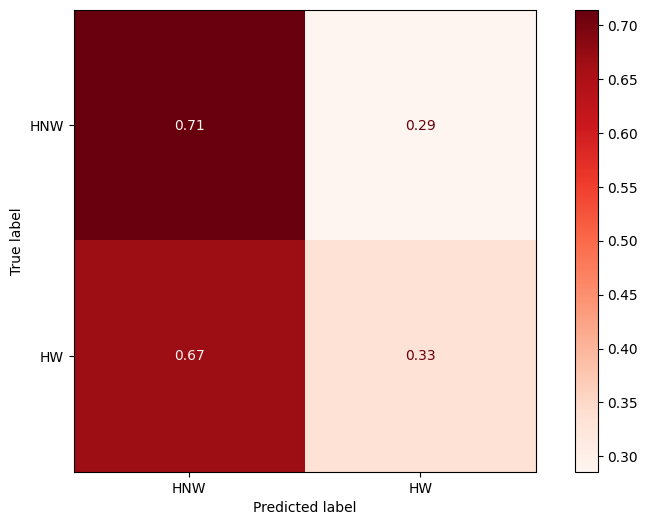

In [4]:
from sklearn import metrics
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
cm = metrics.confusion_matrix(y_tst, xg.predict(X_tst), normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['HNW', 'HW'])
disp.plot(ax=ax, cmap='Reds')

In [5]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_tst, xg.predict(X_tst))
cm

array([[5, 2],
       [2, 1]])

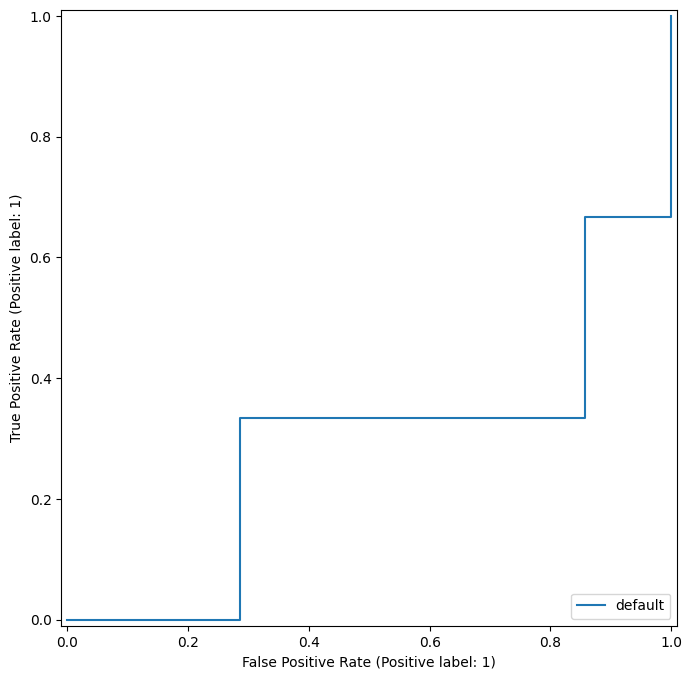

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(xg, X_tst, y_tst,ax=ax, label='default')

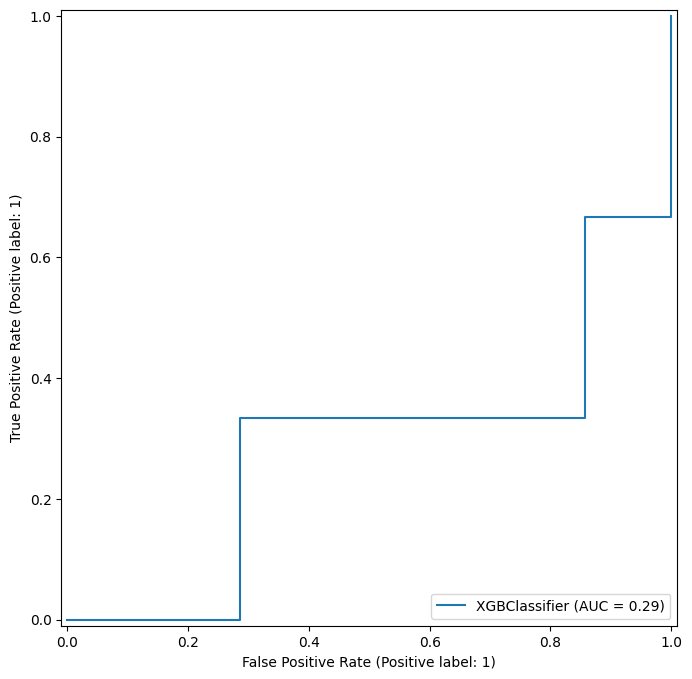

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(xg, X_tst, y_tst,ax=ax)

In [10]:
from src.evaluation.threshold_xgb_classidier import ThresholdXGBClassifier

xgb90 = ThresholdXGBClassifier(xgb=xg, threshold=.1, verbosity=0)
xgb90.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred = xgb90.predict(X_tst)

f1_score(y_tst, y_pred, average='binary').round(3)

np.float64(0.333)